# Project 2: Image Processing - Identifying Road Segment From Satellite Images

This jupyter notebook compares the performance of all models we created.

*Note: Dataset used to compute performance of models can be downloaded [here](https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset/)*.

**Authors:** : [Luca Carroz](https://people.epfl.ch/emilie.carroz), [David Schroeter](https://people.epfl.ch/david.schroeter), [Paulo Ribeiro de Carvalho](https://people.epfl.ch/paulo.ribeirodecarvalho)

<hr style="clear:both">

## Import

In [3]:
from joblib import load
from torchvision.transforms import transforms

from utils.cnn_viewer import CnnViewer
from utils.feature_extraction import extract_images_features, label_to_img
from utils.helpers import *
from utils.performance_dataset import create_performance_dataset
from utils.performance_dataset import display_performance_distribution
from utils.performance_metrics import get_performance_distribution
from utils.random_model import RandomModel


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 ### Load Performance Dataset

In [34]:
image_per_fold = 20
k_folds = 100

img_folds_96, gt_folds_96 = create_performance_dataset(image_per_fold, k_folds)
img_folds_400, gt_folds_400 = create_performance_dataset(image_per_fold, k_folds, split_image=False)
img_folds_logistic, gt_folds_logistic = create_performance_dataset(image_per_fold, k_folds, perform_transformation=False)


## Load Models

Load all models to compare them correctly.

### Random Model

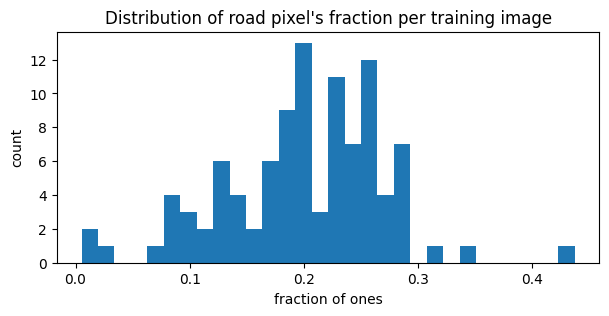

In [35]:
# Load data to initialize the random model
gt_train = load_images("dataset/training/groundtruth")
# Initialize the model
baseline = RandomModel(gt_train)
# Compute the distribution of average number of white pixel per training images
baseline.fit_distribution()
# Compute the random predictions
performance_baseline = baseline.performance_distribution(img_folds_96, gt_folds_96)

### UNet (400x400)

Convolutional Neural Network using UNet architecture. Parameters used for training specified in following code cell. Note that this architecture was trained using input images of size (400, 400).

In [36]:
u_net_400_viewer = CnnViewer('models/u-net/training_save_epoch_60.tar', device='cuda')

performance_u_net_400 = u_net_400_viewer.performance_distribution(img_folds_400, gt_folds_400)

### UNet (96x96)

Convolutional Neural Network using UNet architecture. Parameters used for training specified in following code cell. Note that this architecture was trained using input images of size (96, 96).

In [37]:
u_net_viewer = CnnViewer('models/u-net_96x96/training_save_epoch_85.tar', device='cuda')

performance_u_net_96 = u_net_viewer.performance_distribution(img_folds_96, gt_folds_96)

### DLink Net (96x96)

Convolutional Neural Network using DLink architecture. Parameters used for training specified in following code cell. Note that this architecture was trained using input images of size (96, 96).

In [38]:
d_link_viewer = CnnViewer('models/d-link_96x96/training_save_epoch_50.tar', model_name="DLinkNet", device='cuda')

performance_d_link_96 = d_link_viewer.performance_distribution(img_folds_96, gt_folds_96)

### Logistic Regression



In [4]:
log_reg = load('models/log_reg/log_reg.joblib')

In [62]:
def compute_pred_tensor_logistic_reg(img_fold, gt_fold):
    to_float = transforms.ToTensor()

    mean = np.array([0.33291989, 0.33003242, 0.29571693, 0.0208795, 0.01972159,
                     0.01836854])
    std = np.array([0.12928748, 0.12368662, 0.12883908, 0.02060747, 0.02057139,
                    0.02004493])

    images_pred = []
    for img in img_fold:
        x = (extract_images_features(np.array(img) / 255, 16) - mean) / std

        y_pred = log_reg.predict(x)

        image_pred = label_to_img(96, 96, 16, 16, y_pred)
        images_pred.append(image_pred)

    gt_tensor = torch.stack([to_float(gt) for gt in gt_fold])
    pred_tensor = torch.stack([to_float(pred)/255 for pred in images_pred])

    return pred_tensor, gt_tensor

performance_logistic_reg = get_performance_distribution(img_folds_logistic, gt_folds_logistic, compute_pred_tensor_logistic_reg)

### Box plot performance models comparison

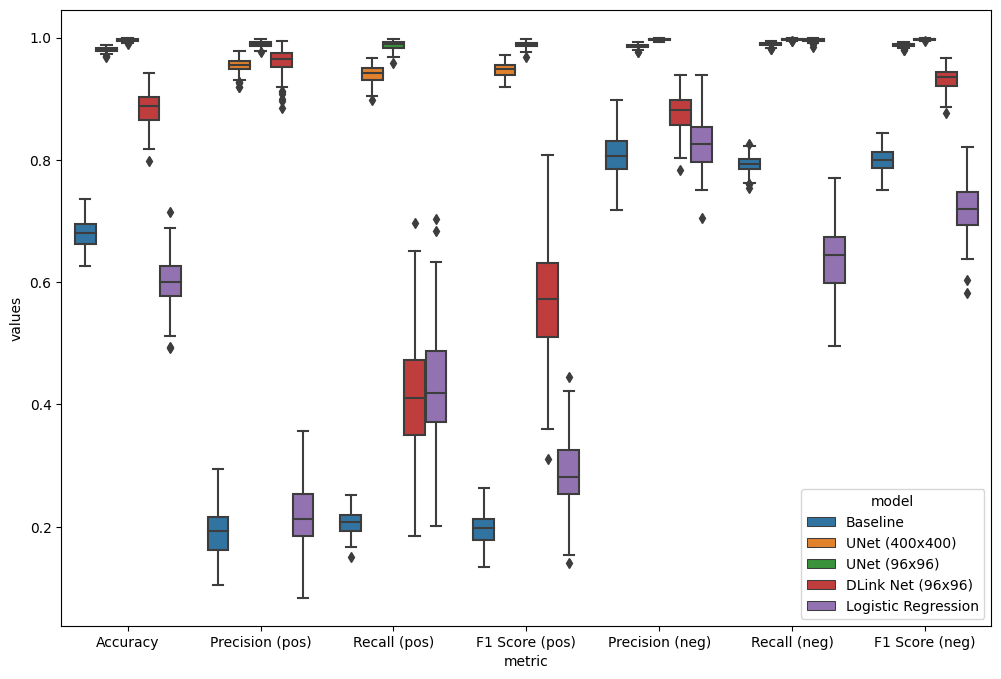

In [63]:
# Set the figure size
fig_size = (12, 8)

# Model to compare
model_names = ["Baseline", "UNet (400x400)", "UNet (96x96)", "DLink Net (96x96)", "Logistic Regression"]

# Fix the name of each computed metric
metric_names = ["Accuracy",
                "Precision (pos)", "Recall (pos)", "F1 Score (pos)",
                "Precision (neg)", "Recall (neg)", "F1 Score (neg)"]

# List the values
performance_values = [performance_baseline, performance_u_net_400, performance_u_net_96, performance_d_link_96,
                      performance_logistic_reg]

display_performance_distribution(model_names=model_names,
                                 metric_names=metric_names,
                                 performance_values=performance_values,
                                 fig_size=fig_size)